# Deep Learning in Structural Engineering
__by Larissa Driemeier$^{[1]}$, Eduardo L. Cabral, Gabriel L. Rodrigues, Lucas P. da Costa, Rafael T. Moura__

<font size="2">${[1]}$ driemeie@usp.br</font> 


This notebook is based on the article [Deep Neural Network application in the nonlinear analysis of a 3D star like bar structure](www.???.???) submitted to the International Journal of Plasticity.

In [ ]:
!nvidia-smi

Sat Mar  6 00:11:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8     9W / 250W |    173MiB / 11170MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Geometry

The figure below shows a star-dome like 3D truss with 24 bars of different cross sectional areas.  The highly nonlinear response, leading to a snap-through effect, makes the structure widely explored as a benchmark for new algorithmighly nonlinear response, leading to a snap-through effect, makes the structure widely explored as a benchmark for new algorithms, quite explored in the literature.


![](https://drive.google.com/uc?export=view&id=1g0e2typbuIsDmVsSaoVHbk2DiGZjV1gv)

The geometry is defined by a random set of 24 different cross section areas. Then, the structure is loaded and analysed in the commercial FE software Abaqus. A table with displacement of the central node and reactions - is provided as output.

The node coordinates and bar numbers are illustrated in Figure below.

![](https://drive.google.com/uc?export=view&id=1uoRaICzsRZtLYEDUsUFwXlLIcrwcSeE9)


For the NN, the areas are the input data and the displacements  and reactions are the output.

## Libraries
Throughout this notebook the new version 2.3.0 of Tersorflow was used, with built-in keras support, which has been recently released to the public.
Follow the instructions in [the official website](https://www.tensorflow.org/install), to guarantee that the right version is installed.

The rest of the libraries used were simply installed using pip, the default Python tool for installing packages. These include:

- NumPy: library for dealing with large matrices and also providing optimized functions for these data structures

- pandas: used to visualize the data and to work with the dataset.

- matplotlib: used to generate plots from the models.

- sklearn (also known as scikit-learn): used because of the many useful functions and utilities it provides for machine learning.

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
from tensorflow import keras
from keras import models
from keras import callbacks

from tensorflow.keras import layers
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU, Dropout

from keras.utils import plot_model
from tensorflow.keras.models import load_model
import pydot

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import h5py
import os

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="whitegrid", palette='Paired', color_codes=True)

import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt

import csv

import gdown


Color pattern used throughout the notebook:

In [ ]:
colors = ['royalblue','lightseagreen', 'forestgreen', 'mediumseagreen']#['midnightblue', 'darkslateblue','mediumslateblue']

## Data Upload

Three files are available to upload in the :
1. the dataset containing the areas, `areas24.csv`;
2. displacements and reaction force along the time, `FinalResult.csv`;
3. the dataset with all models with snap-back instability behaviour,  `Snapback.csv`.

See that `FinalResult.csv` is a huge file, so, it is compressed into 2 parts.

If you prefer to generate your own data, we suggest to use the student version of the software [Abaqus](https://edu.3ds.com/en/software/abaqus-student-edition). The following files are available here:
 1. To generate random areas `generate_areas_24.py`;
 2. Script to run in Abaqus to generate data `24-bar-truss.py`;
 3. Basic geometry to be called by the script mentioned in item 2 `Job-24-bar.inp`.
 4. copy the file `extracted_data_DATA_HOUR.csv` as `FinalResult.csv` to upload.

The file `Negative_Deleted_Values.csv` is uploaded with one example of structure with stability problems, not considered in the training of the DNN.
The files presented in the work are availabe in this [link](https://github.com/ldriemeier/FEA-using-DNN/blob/main/README.md), in the folders *Datasets* and *DataseGeneration*, respectively. 

In [ ]:
#total data: 9910
url1 = 'https://drive.google.com/uc?id=1yMa23O6bgjoaJqHkeqN3lA4An2pocbLW'
url2 = 'https://drive.google.com/uc?id=1Zaee5kIJ8hSpR6FfQ97SpncGVJsXpv4M'
url3 = 'https://drive.google.com/uc?id=1PeautqdDfCaHYof9D5o2RTW1cENkvN1D'
url4 = 'https://drive.google.com/uc?id=1d6G7KluMOO287Z2-XWAZi2cgXSIsRPbR'
areas = 'areas24.csv'
FinalResult = 'FinalResult.csv'
Snapback = 'Snapback.csv'
Negative = 'Negative_Deleted_Values.csv'
gdown.download(url1,areas, quiet=False)
gdown.download(url2,FinalResult, quiet=False)
gdown.download(url3,Snapback, quiet=False)
gdown.download(url4,Negative, quiet=False)

In [ ]:
with open('Snapback.csv') as f:
    data = [int(s) for line in f.readlines() for s in line[:-1].split(',')]

### Geometry

Each set of 24 random areas compounds one complete star-dome like 3D structure. Moreover, a binary These values will be the inputs of the Neural Network.

In [ ]:
areas = pd.read_csv('areas24.csv', index_col='area_id')
areas.index.names = ['ID']
areas['Snapback'] = 0

areas['tmp'] = areas.index
for i in data:
  areas.loc[areas.tmp == i, 'Snapback'] = 1
del areas['tmp']

areas.head(20)

In [ ]:
areas.shape

In [ ]:
zeros, ones = areas['Snapback'].value_counts()
total = zeros + ones
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, ones, 100 * ones / total))

In [ ]:
areas.describe()

Below, the coordinates of the nodes and conectivity of the bars are defined, as in the script to run in Abaqus.

In [ ]:
nbar,nnode = 24, 13

Nodes=[[-433.0,-250.0],
[-250.0,0.0],
[0.0,0.0],
[125.0,216.506351],
[0.0,500.0],
[-125.0,216.506351],
[250.0,0.0],
[125.0,-216.506351],
[-125.0,-216.506351],
[-433.0,250.0],
[433.0,250.0], 
[433.0,-250.0],
[0.0,-500.0]
]
Bars = [[1,  1,  2],
[2,  3,  2],
[3,  4,  3],
[4,  5,  4],
[5,  6,  5],
[6,  4,  6],
[7,  7,  4],
[8,  8,  7],
[9,  9,  8],
[10,  2,  9],
[11,  2,  6],
[12,  6, 10],
[13,  2, 10],
[14,  9,  1],
[15,  3,  9],
[16,  3,  7],
[17, 11,  7],
[18,  4, 11],
[19,  7, 12],
[20,  8, 13],
[21,  3,  8],
[22,  3,  6],
[23, 13,  9],
[24, 12,  8]
]

The stars are plotted with different line thicknesses for each bar, depending on the range of the cross sectional area. 

In [ ]:
n_examples = 4
comb0=[100, 196, 208, 395]
comb1 = [95, 197,209,396]
comb2= [ 220, 554, 690, 1102]#
comb = [comb0, comb1, comb2]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(21,21), sharex=True, sharey=True)
for j in range(3):
  examples = comb[j]
  for k in range(n_examples):
    k2 = examples[k]
    for i in range(nbar):
      index1,index2 = Bars[i][1], Bars[i][2]
      place = areas.iloc[k2-1][i]
      if place <=35:
        c_perc = 0
      elif place > 35 and place <=45:
        c_perc = 1
      elif place > 45 and place <=55:
        c_perc = 2
      elif place > 55 and place <=65:
        c_perc = 3
      elif place > 65 and place <=75:
        c_perc = 4
      else:
        c_perc = 5
      x1, y1 = [Nodes[index1-1][0], Nodes[index2-1][0]], [Nodes[index1-1][1], Nodes[index2-1][1]]
      axs[j,k].plot(x1, y1, linewidth = c_perc+1, color = colors[k])#colors[c_perc])
      axs[j,k].set_aspect('equal')
plt.draw()

Some structures combined areas in such a way that the behaviour presented severe snapback. Such area cimbinations are illustrated below.

In [ ]:
n_examples = 2
severe_snapback_train = [7936,4056,4241,6472,9813,4480,787,9517,8874,2668,3341,1944,8911] #3452
severe_snapback_val = [156,8126,6978,9971,5666,5678,8748]

comb = [156,787,9517]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21,21), sharex=True, sharey=True)
for j in range(3):
    k2 = comb[j]
    for i in range(nbar):
      index1,index2 = Bars[i][1], Bars[i][2]
      place = areas.iloc[k2-1][i]
      if place <=35:
        c_perc = 0
      elif place > 35 and place <=45:
        c_perc = 1
      elif place > 45 and place <=55:
        c_perc = 2
      elif place > 55 and place <=65:
        c_perc = 3
      elif place > 65 and place <=75:
        c_perc = 4
      else:
        c_perc = 5
      x1, y1 = [Nodes[index1-1][0], Nodes[index2-1][0]], [Nodes[index1-1][1], Nodes[index2-1][1]]
      axs[j].plot(x1, y1, linewidth = c_perc+1, color = colors[j])#colors[c_perc])
      axs[j].set_aspect('equal')
plt.draw()

The cross sectional areas are randomly distributed for all bars. The figures below show that the number of times that each bar has a specific cross sectional area is approximately equally distributed within the adopted range.

In [ ]:
areas.hist(column = ['area1', 'area10', 'area20','Snapback'],figsize = (12,10))
plt.show()

### FEA results

Read the results from FEA, where `u3` is the displacement at the central node  $(h=72.16$ $mm)$ and `force` is the reaction force.

There is a force vs displacement curve for each structure, with different set of random areas previously defined.

In [ ]:
output = pd.read_csv('FinalResult.csv')
output.head()

In [ ]:
output.shape

In [ ]:
output.describe()

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(output.corr(),cmap = sns.color_palette("Blues"))
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
output.hist(column = ['u3', 'force'],figsize = (12,10))
plt.show()

The figure below illustrates the negative *ad hoc* behaviour barely found in some special area combinations. Structures with such behaviour were not considered for DNN training.

In [ ]:
negative = pd.read_csv('Negative_Deleted_Values.csv', names=['Disp', 'Force'])
negative.head()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,8), sharey=False)

ax[0].plot(negative['Disp'],negative ['Force']/1000., color=colors[0], linewidth=2)
ax[0].set(xlabel='Imposed displacement in z direction [mm]', ylabel='Reaction Force [kN]',
          title='Negative behaviour')

ax[1].plot(negative['Disp'],negative ['Force']/1000., color=colors[1], linewidth=2)
ax[1].set(xlabel='Imposed displacement in z direction [mm]', ylabel='Reaction Force [kN]',
       title='Zoom')

ax[1].set_xlim([0., 70.])
ax[1].set_ylim([-10., 15.])
plt.show()

## Data manipulation

### Interpolation

Now, let's interpolate the data of all outputs to fix `n_out` FEA points. The objective is to mantain the output vector with constant dimension, altough the number of increments varies according to the nonlinear problem and it is controlled by Abaqus software.

Since force and displacement decrease the values, the interpolation is done in time. However, results with *severe snapback* cointain more points near the snapback region, since the convergence is harder for the FE program. That is why the points are not equally distributed. 

**Important:** see that we're also changing the units of Force to KN, to avoid a considerable difference between displacement and force magnitude for our output. This difference in order of magnitude in the output could impair the performance of the network.

In [ ]:
from scipy.ndimage import interpolation


# In order to have the same output dimensions
n_out = 50

disp = []
forc = []
areaID = np.unique(output.area_id.values)

for i in areaID:
    snap = areas['Snapback'].values[j]
    forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
    disp_aux = output.loc[output['area_id'].isin([i])].u3.values
    time = output.loc[output['area_id'].isin([i])].time.values
    
    dispt = []
    forct = []
    timet = []
    dist = 0.0
    for node in range(1,5):
        dist += np.sqrt((disp_aux[node]-disp_aux[node-1])**2 + (forc_aux[node]-forc_aux[node-1])**2)
        dispt.append(disp_aux[node])
        forct.append(forc_aux[node])
        timet.append(time[node])    
    dist_ave = dist/5.
    dist = 0
    for node in range(6,len(forc_aux)):
        dist += np.sqrt((disp_aux[node]-disp_aux[node-1])**2 + (forc_aux[node]-forc_aux[node-1])**2)
        if dist >= dist_ave:
            dist = 0
            dispt.append(disp_aux[node])
            forct.append(forc_aux[node])
            timet.append(time[node])    
        
# One-dimensional interpolation.
    zoom = n_out/(np.float(len(timet)))
    time1 = interpolation.zoom(timet,zoom,
                            order=2,
                            mode='nearest',
                            prefilter=True)
    forc.append(np.interp(time1, timet, forct))
    disp.append(np.interp(time1, timet, dispt))

forc = np.array(forc)
disp = np.array(disp)
areaID = np.array(areaID)
print(forc.shape,disp.shape,areaID.shape)

As expected, the arrays `forc` and `disp` have the dimension of the number of area combinations vs `n_out`.

Just to illustrate, the interpolated and FEA results are compared graphically.

Below, an example of points distribution in a case considered of severe snapback.

In [ ]:
severe_snapback = [7936,4056,4241,6472,9813,787,156,9578]
i = severe_snapback[6]
disp_aux = output.loc[output['area_id'].isin([i])].u3.values
forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
plt.scatter(disp_aux,forc_aux, color=colors[0], s=30, alpha = 0.1)
j = np.where(areaID == i)
plt.scatter(disp[j][:],forc[j][:], color=colors[1], s=25, label = 'Interpolated values')
plt.title('Force displacement curve \nin 3D star like bar structure')
plt.xlabel('Imposed displacement in z direction [mm]')
plt.ylabel('Reaction Force [kN]')
plt.xlim((0.0,70.))
plt.show()  

Below, the response Force vs Displacement of a selected example is plotted, to illustrate the defined interpolation.

Some area combination numbers with different behaviours,
* Only snapthrough: $100, 196, 208, 395$
* Snapback: $95, 197,209,396$
* Negative: $220, 554, 690, 1102$

In [ ]:
fig, ax = plt.subplots()

ex_snapthrough = [100,196,208,395]
ex_snapback = [95,197,209,396]
ex_negative = [220,554,690,1102]
ex_severe_snapback = [156,787,9517]
ex_comb = [26,95,396, 196]

#change to the behaviour to be analysed
ex = ex_comb

for i,j in zip(ex,range(len(ex))):
  disp_aux = output.loc[output['area_id'].isin([i])].u3.values
  forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
  k = np.where(areaID == i)
#  ax.scatter(disp[k,:], forc[k,:], c=colors[j], s=25, alpha = 0.7)
  ax.plot(disp_aux, forc_aux, color=colors[j], linewidth=2, label = 'Structure ID = '+str(i))

ax.set(#title='Force displacement curve \nin 3D star like bar structure',
       xlabel='Imposed displacement in z direction [mm]',
       ylabel='Reaction Force [kN]');
plt.legend()
plt.xlim((0.0,70.))
plt.ylim((-10.,20.0))

plt.show()   

In [ ]:
examples = [2501,16,11,787,95,9360,156,5601] #[2501,16,11,3526,95,9360,396,1321]
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True,figsize=(25,10))
k,l = 0,0
for i,j in zip(examples,range(len(examples))):
  m = np.where(areaID == i)
  if j<len(examples)/2:
    axs[0,k].scatter(disp[m,:], forc[m,:], c= colors[0], s=20)
    axs[0,k].set_title('Structure ID '+str(i))
    k = k + 1
  else:
    axs[1,l].scatter(disp[m,:], forc[m,:], c = colors[0],s=20)
    axs[1,l].set_title('Structure ID '+str(i))
    l = l + 1
fig.suptitle('Random examples') 
# set labels
plt.setp(axs[-1, :], xlabel='Displacement [mm]',xlim = (0.,70.))
plt.setp(axs[:, 0], ylabel='Force [KN]')

Now, the `DisplacementForce` array will be generated concatenating the arrays `areaID`, `disp` and `forc`. 

See that, for any line $i$ in `DisplacementForce`, the first `n_out` columns are the displacements and the last `n_out` columns are the forces.

In [ ]:
DisplacementForce = np.concatenate((disp,forc),axis=1)

print(DisplacementForce.shape)

### Splitting dataset

The input for the NN is a vector with all 24 areas that compound the geometry of the structure. Remember that we mantain all other parameters, such as material properties and dimensions, fixed. The outputs are the curves Displacements vs Forces are stored in an array `DisplacementsForces`.

Although, in general, the dataset is divided into *training, validation and testing sets*, here we'll have only *training and validation*. 

The validation set is used when *adjusting the model* to assess the cost function and other metrics, however, the model does not fit this data. The test set is not used during the training phase and is only used at the end to assess *how well the model generalizes to new data*. The test data is, in general, used to evaluate the performance of the model to deliver in the market, which is not our case.

### Rescaling dataset

The next logical step in the preprocessing pipeline is to scale the features. 
Many machine learning methods expect or are more effective if the data attributes have the same scale. There are three popular data scaling methods:


```
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler().fit(x_train)
scaler = preprocessing.MaxAbsScaler().fit(x_train)
scaler = preprocessing.MinMaxScaler().fit(x_train)
```

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance). It is useful to standardize attributes for a model that relies on the distribution of attributes such as Gaussian processes.

We're using the `MinMaxScaler`, since our output can contain negative values. 
It is, in general, used for data that is already centered at zero or sparse data. 

Before applying any scaling transformations it is very important to split the data into a train set and a test set, as we already did.

The rescaling is made based on training values and the same parameters are used to rescale the validation set.

The output data will be also rescaled, since the values of the displacements vary in many orders of magnitude from the forces. Again, based on the training set.

The normalizer of the sklearn library was used to facilitate the process. The `inverse_transform` can be used, later, to recover the real values.

During scaling, the data lies within the range $[-1, 1]$ by dividing through the largest maximum value in each feature.

As an alternative suggestion, scaling should be in the range [-0.8, 0.8] in order to keep a scope for normalization of validation/test data that are outside the range of training samples.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(areas, DisplacementForce, test_size=0.1, random_state=18) 
areas_train = x_train.index.values
areas_val = x_val.index.values

# Turns input and output data into Numpy tensors
x_train_sca = np.array(x_train)
x_val_sca = np.array(x_val)
y_train_sca = np.array(y_train)
y_val_sca = np.array(y_val)

print('Dimension of training inputs    :', x_train.shape)
print('Dimension of validation inputs  :', x_val.shape)

print('Dimension of training outputs   :', y_train.shape)
print('Dimension of validation outputs :', y_val.shape)

# Scaling the input data using the MinMaxScaler from scikit-learn
scaler_x = preprocessing.MinMaxScaler().fit(x_train)
x_train_sca = scaler_x.transform(x_train)
x_val_sca = scaler_x.transform(x_val)

# Normalizing the output data using the normalizer from scikit-learn
normalizer_y = preprocessing.MinMaxScaler(feature_range = (-0.9,0.9)).fit(y_train)#StandardScaler,MaxAbsScaler
y_train_sca = normalizer_y.transform(y_train)
y_val_sca = normalizer_y.transform(y_val)


#  Min and Max in input
min_x_train = np.min(x_train_sca)
min_x_val = np.min(x_val_sca)
max_x_train = np.max(x_train_sca)
max_x_val = np.max(x_val_sca)

# Mean and Standard Deviation in Output
min_y_train = np.min(y_train_sca)#mean
min_y_val = np.min(y_val_sca)
max_y_train = np.max(y_train_sca)#std
max_y_val = np.max(y_val_sca)


print(f'For the input training set, the min is {min_x_train} and the max is {max_x_train}')
print(f'For the input validation set, the min is {min_x_val} and the max is {max_x_val}')
print(f'For the output train set, the min is {min_y_train} and the max is {max_y_train}')
print(f'For the output validation set, the min is {min_y_val} and the max is {max_y_val}')

The plot below shows the de-scale of validation values back to their original values.

In [ ]:
plt.scatter(y_val[100][0:n_out],y_val[100][-n_out:], s=50, label = 'Original')
yy=normalizer_y.inverse_transform(y_val_sca)
plt.scatter(yy[100][0:n_out],yy[100][-n_out:], s=4, label = 'Inverse transformation')
plt.title('Inverse transformation of scaled data')
plt.xlabel('Displacement [mm]')
plt.ylabel('Force [N]')
plt.xlim((0.0,70.))
plt.legend()
plt.show()

### Functions

The functions below will help to plot comparative graphs.

In [ ]:
# graph generation for training and validation sets
def predict_curves(name,pred_sca, y, areas, ex = [200,194,71,31,14,0]):
  colors = ['royalblue','lightseagreen', 'forestgreen', 'mediumseagreen']
  y_new = normalizer_y.inverse_transform(pred_sca)
  fig, ax = plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, constrained_layout=True,figsize=(20,5))
  for i,j in zip(ex,range(len(ex))):
    k = areas[i]
    ax[j].plot(y[i][0:n_out],y[i][-n_out:],color = colors[0])
    ax[j].scatter(y_new[i][0:n_out],y_new[i][-n_out:],s=8, color = colors[1])
    ax[j].legend(['Target', 'Predicted'])
    ax[j].set_title('Structure ID'+str(k))
    ax[j].set_xlabel('Displacement [mm]')
    ax[j].set_ylabel('Reaction Force [kN]')
#  plt.xlim((0,70))
  if name =='train':
    plt.setp(ax, xlim=(0.,70.))
    fig.suptitle('Training set', fontsize=18)
  if name =='val':
    plt.setp(ax, xlim=(0.,70.))
    fig.suptitle('Validation set', fontsize=18)
  plt.show()

# ResNet
### ResNet - Residual network

According to  [He et al. (2015)](https://arxiv.org/pdf/1512.03385.pdf) deeper neural networks are more difficult to train, so, they proposed a *residual learning framework* to ease the training of convolutional networks that are substantially deep.

With the network depth increases, accuracy gets saturated and then degrades rapidly. Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error. The figure below was extracted from the original article He et al. (2015).

 ![](https://drive.google.com/uc?export=view&id=1Oqc6ofxBuvJrH_kE7jVOEfV4hG4PRiy2)

*ResNet* has a block called *Residual Block* that consists of a shortcut between two layers of the non-neighboring network. The shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers.

Identity shortcut connections add neither extra parameter nor computational complexity. 

The residual block makes it easier to train very deep RNAs. For convolutional networks, see the [link](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8). For fully connected layers, see details in the [work](https://www.mdpi.com/1099-4300/22/2/193):
Dongwei Chen, Fei Hu, Guokui Nian and Tiantian Yang, *Deep Residual Learning for Nonlinear Regression*, Entropy, January 2020.

*Based on the structure of ResNet, we build a new neural network for nonlinear regression. Its architecture is presented in Figure 2. Convolutional layers and pooling layers are replaced by fully connected layers (or dense layers) in the residual block. Batch Normalization layers from the primary model are kept in our new model, which act as a regularizer in some cases, eliminating the need for Dropout, and allow people to use much higher learning rates and care less about initialization.(...)*
<font size="2">Extracted from Chen et al (2020)</font>

The figure and table below shows identity and dense blocks  proposed by Chen et al (2020) and adopted in our architecture.

![](https://drive.google.com/uc?export=view&id=1CCML2jBvVvs32L-YLjh2W7FAZFgIDrei)


>Type of block | Input shape | Output shape | Activation Function | Same size I/O
>--- | --- | --- | --- | --- 
>Input | (1,24) | (1, None*) | ReLU | False
>Dense | (1,N2) |(1, N3) | ReLU | False
>Identity | (1,N1) |(1, N1) | ReLU | True
>Output | (1,None) | (1, None*) | Linear | False

<font size="2">*None  means the size of input in this dimension is uncertain.</font>

In [ ]:
def sequential_block(input_tensor,units, activation = 'lrelu', lamb = 0.1):
	"""The identity block is the block that has no conv layer at shortcut.
	# Arguments
		input_tensor: input tensor
		units:output shape
	# Returns
		Output tensor for the block.
	"""

	if activation == 'tanh':
	  activation = activation
	else:
	  activation = LeakyReLU(alpha=0.01)
    
	units1 = 4.0*units
	units2 = 3.0*units
	units3 = 2.0*units
	units4 = 2.0*units

	x = layers.Dense(units1, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units2, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units3, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units4, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)
 
	return x

##
## https://github.com/DowellChan/ResNetRegression/blob/master/ResNetOptimalModel.py

def identity_block(input_tensor,units, activation = 'lrelu', lamb = 0.1):
	"""The identity block is the block that has no conv layer at shortcut.
	# Arguments
		input_tensor: input tensor
		units:output shape
	# Returns
		Output tensor for the block.
	"""

	if activation == 'tanh':
	  activation = activation
	else:
	  activation = LeakyReLU(alpha=0.01)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)

	x = layers.add([x, input_tensor])
	x = layers.Activation(activation)(x)

	return x

def dens_block(input_tensor,units, activation = 'lrelu', lamb = 0.1):
	"""A block that has a dense layer at shortcut.
	# Arguments
		input_tensor: input tensor
		unit: output tensor shape
	# Returns
		Output tensor for the block.
	"""
    
    
	if activation == 'tanh':
	  activation = activation
	else:
	  activation = LeakyReLU(alpha=0.01)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation(activation)(x)

	x = layers.Dense(units, use_bias=False, kernel_regularizer=keras.regularizers.l2(lamb))(x)
	x = layers.BatchNormalization()(x)

	shortcut = layers.Dense(units, use_bias=False)(input_tensor)
	shortcut = layers.BatchNormalization()(shortcut)


	x = layers.add([x, shortcut])
	x = layers.Activation(activation)(x)
	return x

In [ ]:
def DNNeReg(n_out,n_neurons):
	"""Instantiates the ResNet50 architecture.
	# Arguments        
		input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
			to use as input for the model.        
	# Returns
		A Keras model instance.
	"""
	Res_input = layers.Input(shape=(25,))

	width = 1.5* n_neurons

	x0 = sequential_block(Res_input,width,activation='tanh')
 
#First Block
	x = dens_block(x0,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	shortcut = layers.Dense(width, use_bias=False)(x0)
	shortcut = layers.BatchNormalization()(shortcut)
	x1 = layers.add([x, shortcut])
    
#Second Block    
	x = dens_block(x1,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	shortcut = layers.Dense(width, use_bias=False)(x1)
	shortcut = layers.BatchNormalization()(shortcut)
	x2 = layers.add([x, shortcut])

#Third Block
	x = dens_block(x2,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
 
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	

	shortcut = layers.Dense(width, use_bias=False)(x2)
	shortcut = layers.BatchNormalization()(shortcut)
	x3 = layers.add([x, shortcut])

#Fourth Block
	x = dens_block(x3,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	shortcut = layers.Dense(width, use_bias=False)(x3)
	shortcut = layers.BatchNormalization()(shortcut)
	x4 = layers.add([x, shortcut])

#Fith Block
	x = dens_block(x4,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	x = dens_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	x = identity_block(x,width,activation='tanh')
	
	shortcut = layers.Dense(width, use_bias=False)(x3)
	shortcut = layers.BatchNormalization()(shortcut)
	x = layers.add([x, shortcut])
	
	x = layers.BatchNormalization()(x)  
	x = layers.Dense(n_out,activation='tanh')(x)
	model = models.Model(inputs=Res_input, outputs=x)

	return model

The model has very long recursion and it exceeds the program's default limit. See below the explanation to increase in the recursion limit.

*`sys.setrecursionlimit()` method is used to set the maximum depth of the Python interpreter stack to the required limit. This limit prevents any program from getting into infinite recursion, otherwise infinite recursion will lead to overflow of the C stack and crash the Python.*

<font size="2">Extracted from [this link](https://www.geeksforgeeks.org/python-sys-setrecursionlimit-method/)</font>

In [ ]:
import sys
print(sys.getrecursionlimit())

In [ ]:
sys.setrecursionlimit(1500)

In [ ]:
n_neurons = 2*n_out

model = DNNeReg(2*n_out,n_neurons)
model.summary()  
opt = keras.optimizers.Adam(learning_rate = 0.01, decay = 0.05)

model.compile(optimizer = opt,
                loss='mean_squared_error',
                metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

In [ ]:
plot_model(model, to_file='NN_24bars.png', show_shapes=True)

#### Training the ResNet and saving weights

You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The `tf.keras.callbacks.ModelCheckpoint` callback allows you to continually save the model both *during* and at *the end* of training.

In [ ]:
n_epochs = 14000
batch_size = 1024
stop = EarlyStopping(monitor='val_loss', patience=10,verbose=2, mode='auto')

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 3000 epochs
cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                              verbose=1, save_weights_only=True,
                              save_freq=4*batch_size)

patience = 100
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                         patience=patience, min_delta=1E-7)

In [ ]:
starttime = datetime.datetime.now()
print('{:%Y-%m-%d %H:%M}'.format( starttime ))


# fit model
history = model.fit(x_train_sca, y_train_sca, epochs=n_epochs, 
                    batch_size=batch_size, 
                    verbose=0, callbacks=[rlrp, cp_callback], 
                    validation_data=(x_val_sca, y_val_sca)
                    )
endtime = datetime.datetime.now()

print('{:%Y-%m-%d %H:%M}'.format( endtime))



epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], color = colors[0])
plt.plot(epochs, history.history['val_loss'], color = colors[1])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Resnet Performance')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim((0.0,3000))
plt.xlim((0,15000))
plt.show()

In [ ]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], color = colors[0])
plt.plot(epochs, history.history['val_loss'], color = colors[1])
plt.legend(['Training loss', 'Validation loss'])
#plt.title('Resnet Performance')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim((0.0,0.02))
plt.xlim((0,15000))
plt.show()

In [ ]:
pred_sca_train = model.predict(x_train_sca)
pred_sca_val = model.predict(x_val_sca)
print(pred_sca_val.shape,pred_sca_train.shape)

In [ ]:
predict_curves('train',pred_sca_train, y_train, areas_train, ex = [3733,4387,3011,2312,6006,7731]) 
predict_curves('val',pred_sca_val, y_val, areas_val, ex = [335,8,511,409,925,775])

In [ ]:
y_pred_train = normalizer_y.inverse_transform(pred_sca_train)
y_pred_val = normalizer_y.inverse_transform(pred_sca_val)

Plot graphs with severe snapback

9517
787


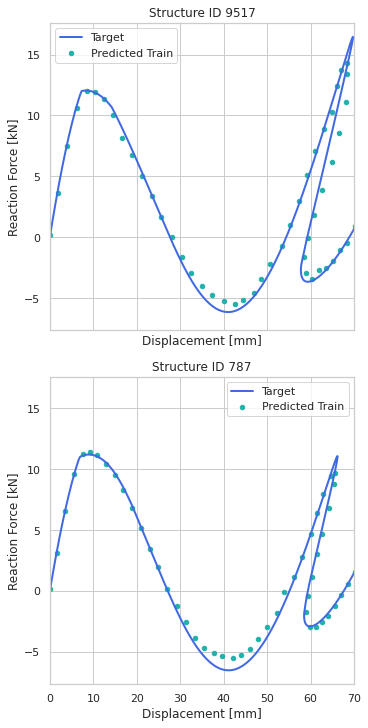

36


In [ ]:
severe_snapback_train = [7936,4056,4241,6472,9813,4480,787,9517,8874,2668,3341,1944,8911] 
severe_snapback_val = [156,8126,6978,9971,5666,5678,8748]

severe_snapback = [9517, 787]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, constrained_layout=True,figsize=(5,10))
ax = ax.flatten()

for j in range(2):
    i = severe_snapback[j]
    print(i)
    disp_aux = output.loc[output['area_id'].isin([i])].u3.values
    forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
    ax[j].plot(disp_aux,forc_aux, color=colors[0], linewidth=2)
    try:
        k = np.where(areas_train == i)
        index = k[0][0]
        ax[j].scatter(y_pred_train[index][0:n_out],y_pred_train[index][-n_out:],s=20, color = colors[1])
        ax[j].legend(['Target', 'Predicted Train'])
        ax[j].set_xlabel('Displacement [mm]')
        ax[j].set_ylabel('Reaction Force [kN]')
        ax[j].set_title('Structure ID '+str(i))
    except:
        k = np.where(areas_val == i)
        index = k[0][0]
        ax[j].scatter(y_pred_val[index][0:n_out],y_pred_val[index][-n_out:],s=20, color = colors[1])
        ax[j].legend(['Target', 'Predicted Validation'])
        ax[j].set_xlabel('Displacement [mm]')
        ax[j].set_ylabel('Reaction Force [kN]')
        ax[j].set_title(' ID '+str(i))
        
plt.xlim((0.0,70.))
plt.show()
print(areas_train[1782])

## Metrics

The first peak force is calculated for the following data sets:
* processed results from FEA with 50 points;
* results of DNN from validation set;
* results of DNN from training set;
and compared with the original values obtained from FEA.

In [ ]:
MaxForce_train = []
MaxForce_val = []
MaxForce = []
MaxForce_50 = []


for i in range(len(pred_sca_train)):
    disp_masked = np.ma.masked_where((y_pred_train[i,0:49] < 0.) | (y_pred_train[i,0:49] > 12.), y_pred_train[i,0:49])
    forc_masked = np.ma.masked_where(disp_masked.mask, y_pred_train[i,0+50:49+50])
    valueForce = np.max(forc_masked)
    index = np.argmax(forc_masked)
    valueDisp = y_pred_train[i,index]
    area = areas_train[i]
    MaxForce_train.append([area,valueDisp,valueForce])
MaxForce_train = np.array(MaxForce_train)

for i in range(len(pred_sca_val)):
    disp_masked = np.ma.masked_where((y_pred_val[i,0:49] < 0.) | (y_pred_val[i,0:49] > 12.), y_pred_val[i,0:49])
    forc_masked = np.ma.masked_where(disp_masked.mask, y_pred_val[i,0+50:49+50])
    valueForce = np.max(forc_masked)
    index = np.argmax(forc_masked)
    valueDisp = y_pred_val[i,index]
    area = areas_val[i]
    MaxForce_val.append([area, valueDisp,valueForce])
MaxForce_val = np.array(MaxForce_val)

for i in areaID:
    disp_aux = output.loc[output['area_id'].isin([i])].u3.values
    forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
    disp_masked = np.ma.masked_where((disp_aux < 0.) | (disp_aux > 12.), disp_aux)
    forc_masked = np.ma.masked_where(disp_masked.mask, forc_aux)
    valueForce = np.max(forc_masked)
    index = np.argmax(forc_masked)
    valueDisp = disp_masked[index]
    MaxForce.append([i,valueDisp,valueForce])
MaxForce = np.array(MaxForce)

for i in areaID:
    a = np.where(areaID == i)
    disp_aux =np.squeeze( disp[a,:])
    forc_aux = np.squeeze(forc[a,:])
    disp_masked = np.ma.masked_where((disp_aux < 0.) | (disp_aux > 12.), disp_aux)
    forc_masked = np.ma.masked_where(disp_masked.mask, forc_aux)
    valueForce = np.max(forc_masked)
    index = np.argmax(forc_masked, axis = 0)
    valueDisp = disp_masked[index]
    MaxForce_50.append([i,valueDisp,valueForce])
MaxForce_50 = np.array(MaxForce_50)

print('Dimension of maximum values in validation dataset       :', MaxForce_val.shape)
print('Dimension of maximum values in train dataset            :', MaxForce_train.shape)
print('Dimension of maximum values in Abaqus dataset           :', MaxForce.shape)
print('Dimension of maximum values in Abaqus dataset 50 points :', MaxForce_50.shape)

MaxForce_all =[MaxForce[np.argmax(MaxForce[:,2]),0],MaxForce_50[np.argmax(MaxForce_50[:,2]),0], 
                 MaxForce_train[np.argmax(MaxForce_train[:,2]),0],
                 MaxForce_val[np.argmax(MaxForce_val[:,2]),0]]
print('The structures with maximum load, in the four datasets, are, respectively:')
print('{:d},{:d},{:d},{:d}'.format(int(MaxForce_all[0]),int(MaxForce_all[1]),int(MaxForce_all[2]),int(MaxForce_all[3])))

The error between the maximum force in FEA and DNN.

In [ ]:
error_train = []
error_val = []
error_50 = []


for i in range(len(MaxForce_train)):
    aux = np.where(MaxForce_50 == int(MaxForce_train[i,0]))
    index = aux[0][0]
    error_train.append(np.abs(MaxForce_50[index,2]-MaxForce_train[i,2])) 
error_train = np.array(error_train)

for i in range(len(MaxForce_val)):
    aux = np.where(MaxForce_50 == int(MaxForce_val[i,0]))
    index = aux[0][0]
    error_val.append(np.abs(MaxForce_50[index,2]-MaxForce_val[i,2])) 
error_val = np.array(error_val)

for i in range(len(MaxForce)):
    error_50.append(np.abs(MaxForce[i,2]-MaxForce_50[i,2])) 
error_50 = np.array(error_50)

print('Dimension of error in train set          :', error_train.shape)
print('Dimension of error in validation set     :', error_val.shape)
print('Dimension of error due to interpolation  :', error_50.shape)

Plotting graphs with the maximum error.

In [ ]:
max_error_train = np.argmax(error_train)
max_error_val = np.argmax(error_val)
max_error_50 = np.argmax(error_50)

arg_errors = [max_error_train,max_error_val,max_error_50]
areaID_errors = [MaxForce_train[max_error_train,0],MaxForce_val[max_error_val,0],MaxForce_50[max_error_50,0]]
    
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, constrained_layout=True,figsize=(20,5))

for i,j in zip(areaID_errors,range(3)):
    disp_aux = output.loc[output['area_id'].isin([i])].u3.values
    forc_aux = output.loc[output['area_id'].isin([i])].force.values/1000.
    ax[j].plot(disp_aux,forc_aux, color=colors[0], linewidth=2, alpha = 0.6)
    if j ==0: 
        k = np.where(areas_train == i)
        index = k[0][0]
        ax[j].scatter(y_pred_train[index][0:n_out],y_pred_train[index][-n_out:],s=20, color = colors[1])
        ax[j].legend(['Target', 'Predicted Train'])
        ax[j].set_xlabel('Displacement [mm]')
        ax[j].set_ylabel('Reaction Force [kN]')
        ax[j].set_title('Structure ID '+str(i))

    elif j == 1:
        k = np.where(areas_val == i)
        index = k[0][0]
        ax[j].scatter(y_pred_val[index][0:n_out],y_pred_val[index][-n_out:],s=20, color = colors[1])
        ax[j].legend(['Target', 'Predicted Validation'])
        ax[j].set_xlabel('Displacement [mm]')
        ax[j].set_ylabel('Reaction Force [kN]')
        ax[j].set_title('Structure ID '+str(i))

    else:
        k = np.where(areaID == i)
        index = k[0][0]
        ax[j].scatter(disp[index,:], forc[index,:],s=20, color = colors[1])
        ax[j].legend(['Abaqus', 'Interpolation'])
        ax[j].set_xlabel('Displacement [mm]')
        ax[j].set_ylabel('Reaction Force [kN]')
        ax[j].set_title('Structure ID '+str(i))
        
        
plt.xlim((0.0,70.))
plt.show()

In [ ]:

data =np.array([[np.max(MaxForce[:,2]),np.max(MaxForce_50[:,2]), 
                 np.max(MaxForce_train[:,2]),np.max(MaxForce_val[:,2])],    
        [np.mean(MaxForce[:,2]),np.mean(MaxForce_50[:,2]),
         np.mean(MaxForce_train[:,2]),np.mean(MaxForce_val[:,2])],
        [np.std(MaxForce[:,2]),np.std(MaxForce_50[:,2]),
         np.std(MaxForce_train[:,2]),np.std(MaxForce_val[:,2])],
        [None, None, np.max(error_train),np.max(error_val)]
       ])

# pass column names in the columns parameter 
df = pd.DataFrame(data)

df = pd.DataFrame(data,
                  columns=['Abaqus value','Abaqus 50 points', 'Train value', 'Validation value'],
                  index=['Maximum', 'Mean', 'Std', 'Error']
)

df

In [ ]:
Percentage =  [np.max(error_train)/np.max(MaxForce_train[:,2]),np.max(error_val)/np.max(MaxForce_val[:,2])]
print(Percentage)

[0.12505400183591323, 0.18561752992484123]


In [ ]:
model.save('OptimalModel.h5')